# Connectivity Analysis Pipeline

## Load functional data

In [1]:
# import nilearn newest version (make sure it is 0.7.1 or more)
import nilearn
nilearn.__version__

'0.7.1'

In [2]:
from nilearn.datasets import fetch_development_fmri

# One subject of brain development fmri data
data = fetch_development_fmri(n_subjects=10)

/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Load Parcellation

In [3]:
# import brainscapes 0.0.8.7.2
import brainscapes as bs
bs.logger.setLevel("INFO")
atlas = bs.atlases.MULTILEVEL_HUMAN_ATLAS
# Select Difumo 64
atlas.select_parcellation(atlas.parcellations[6])
atlas.selected_parcellation.name

[brainscapes:INFO]  Selected parcellation "Dictionary of functional modes (64 dimensions)"


'Dictionary of functional modes (64 dimensions)'

In [7]:
from nilearn.image import get_data
maps = atlas.get_maps(atlas.spaces[0])['whole brain']
maps.shape

(104, 123, 104)

In [8]:
import numpy as np
labels = ["Background"]
for label_desc in atlas.selected_parcellation.regions:
    label_name = label_desc['name']
    label_idx = label_desc['labelIndex']
    print(f"Label index {label_idx} is '{label_name}'")
    labels.append(label_name)
assert len(labels) == len(np.unique(get_data(maps)))

Label index 1 is 'Superior frontal sulcus'
Label index 2 is 'Fusiform gyrus'
Label index 3 is 'Calcarine cortex posterior'
Label index 4 is 'Cingulate cortex posterior'
Label index 5 is 'Parieto-occipital sulcus superior'
Label index 6 is 'Insula antero-superior'
Label index 7 is 'Superior temporal sulcus with angular gyrus'
Label index 8 is 'Planum temporale'
Label index 9 is 'Cerebellum Crus II'
Label index 10 is 'Superior parts of Postcentral and Precentral gyri'
Label index 11 is 'Transverse sinus'
Label index 12 is 'Paracentral gyrus RH'
Label index 13 is 'Superior occipital gyrus'
Label index 14 is 'Cingulate gyrus mid-posterior'
Label index 15 is 'ventricles'
Label index 16 is 'Fusiform gyrus posterior'
Label index 17 is 'Superior frontal gyrus medial'
Label index 18 is 'Precuneus superior'
Label index 19 is 'Planum polare'
Label index 20 is 'Parieto-occipital sulcus middle'
Label index 21 is 'Cerebellum I-V'
Label index 22 is 'Superior fornix and isthmus'
Label index 23 is 'Ant

## Extract signals from parcellation and functional data

In [9]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import new_img_like

# Use NiftiLabelsMasker to extract signals from regions
masker = NiftiLabelsMasker(labels_img=maps, 
                           standardize=True)
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, 
                                            confounds=confounds))
time_series = np.array(time_series)
time_series.shape

(10, 168, 64)

## Compute connectivity matrix from signals

In [10]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform(time_series)
assert correlation_matrix.shape == (10, 64, 64)
mean_correlation_matrix = correlation_measure.mean_
assert mean_correlation_matrix.shape == (64, 64)

## Plot connectivity as matrix and as a graph

/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:22: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  ylabel_width = ax.yaxis.get_tightbbox(renderer).inverse_transformed(
/home/nicolas/anaconda3/envs/brainscapes/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:30: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  xlabel_height = ax.xaxis.get_tightbbox(renderer).inverse_transformed(


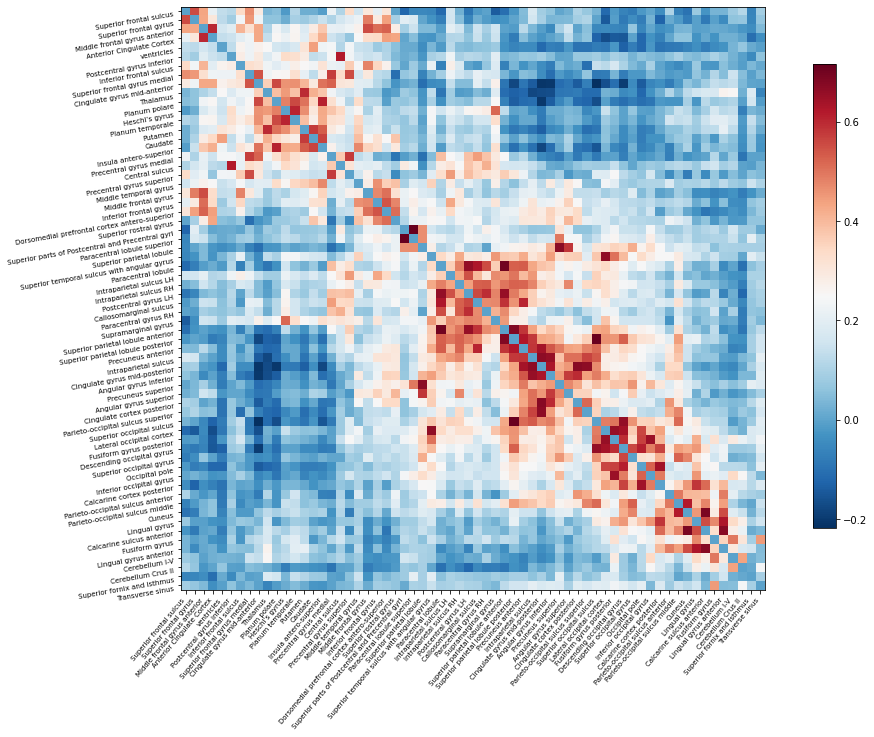

In [11]:
from nilearn.plotting import plot_matrix
# Mask the main diagonal for visualization:
np.fill_diagonal(mean_correlation_matrix, 0)
# matrices are ordered for block-like representation
plot_matrix(mean_correlation_matrix, 
            figure=(12, 12), 
            labels=labels[1:], 
            reorder=True)

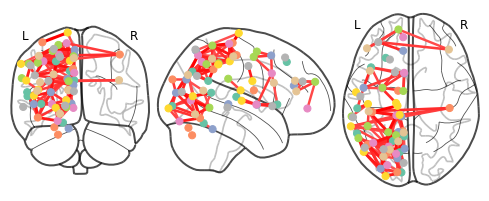

In [12]:
from nilearn.plotting import plot_connectome, find_parcellation_cut_coords

# grab center coordinates for atlas labels
coordinates = find_parcellation_cut_coords(labels_img=maps)
# plot connectome with 95% edge strength in the connectivity
plot_connectome(mean_correlation_matrix, 
                coordinates,
                edge_threshold="95%")

## Export

TODO...